In [1]:
from covid_analysis import *

%matplotlib inline
sns.set(style="whitegrid")
FIGSIZE = [12, 8]

# México

In [2]:
estados_analisis = ["Ciudad de México", "Nuevo León", "Jalisco", "Queretaro"]
estados = load_mariorz()
mexico = {}
for ds_name, ds in estados.items():
    mexico[ds_name] = pd.DataFrame({'Mexico': ds.sum(axis=1)})

## Resumen

### Fecha de Actualización:

In [3]:
mexico['confirmados'].index[-1].strftime("%d-%m-%Y")

'30-05-2020'

### Confirmados

In [4]:
sum(mexico['confirmados'].iloc[-1])

87512

### Nuevos Confirmados

In [5]:
sum(mexico['daily_confirmados'].iloc[-1])

2885

### Fallecimientos

In [6]:
sum(mexico['muertos'].iloc[-1])

9779

### Nuevos Fallecimientos

In [7]:
sum(mexico['daily_muertos'].iloc[-1])

364

## Nacional

### México: Confirmados acumulados

,Mexico
Date,
2020-05-17,49219
2020-05-18,51633
2020-05-19,54346
2020-05-20,56594
2020-05-21,59567
2020-05-22,62527
2020-05-23,65856
2020-05-24,68620
2020-05-25,71105


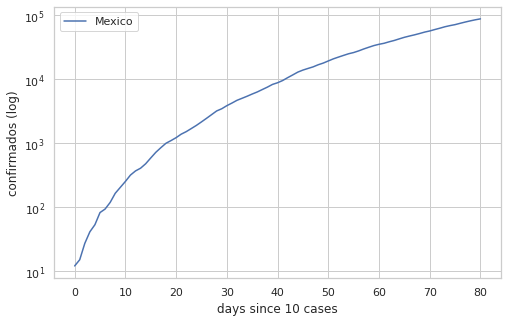

In [8]:
analysis(mexico, ["Mexico"], "confirmados", log=True, smooth=False, since=10)

### México: Confirmados diarios

,Mexico
Date,
2020-05-17,2075
2020-05-18,2414
2020-05-19,2713
2020-05-20,2248
2020-05-21,2973
2020-05-22,2960
2020-05-23,3329
2020-05-24,2764
2020-05-25,2485


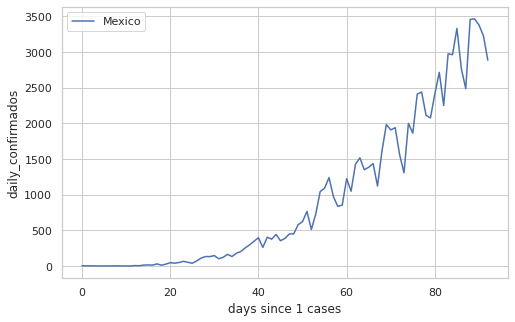

In [9]:
analysis(mexico, ["Mexico"], "daily_confirmados", since=1, smooth=False, log=False)

### México: Fallecimientos acumulados

,Mexico
Date,
2020-05-17,5177
2020-05-18,5332
2020-05-19,5666
2020-05-20,6090
2020-05-21,6510
2020-05-22,6989
2020-05-23,7179
2020-05-24,7394
2020-05-25,7633


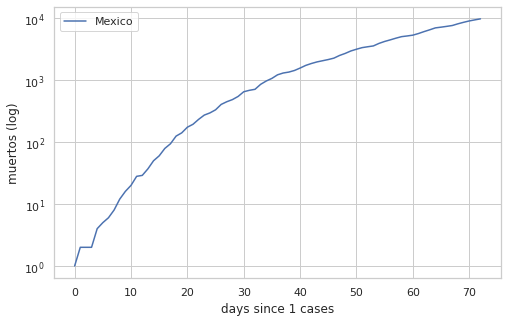

In [10]:
analysis(mexico, ["Mexico"], "muertos", since=1, smooth=False, log=True)

### México: Fallecimientos diarios

,Mexico
Date,
2020-05-17,132
2020-05-18,155
2020-05-19,334
2020-05-20,424
2020-05-21,420
2020-05-22,479
2020-05-23,190
2020-05-24,215
2020-05-25,239


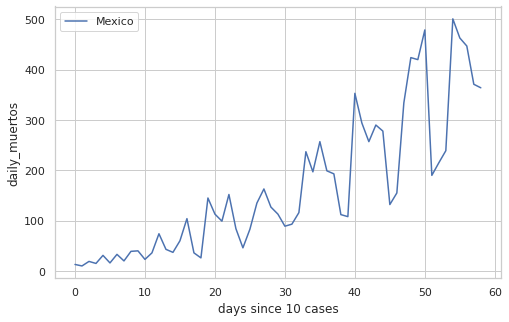

In [11]:
analysis(mexico, ["Mexico"], "daily_muertos", since=10, smooth=False, log=False)

### México: Pruebas reportadas por día, acumuladas

,Mexico
Date,
2020-05-17,172294
2020-05-18,177133
2020-05-19,185775
2020-05-20,193589
2020-05-21,201838
2020-05-22,210070
2020-05-23,215656
2020-05-24,219164
2020-05-25,225650


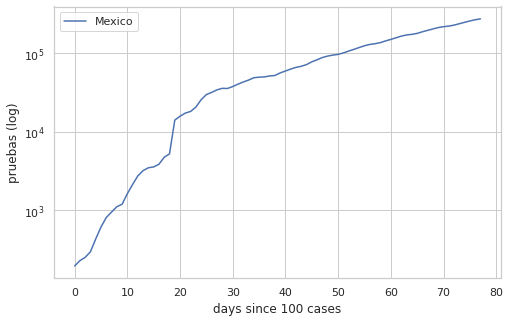

In [12]:
mexico['pruebas'] = mexico['confirmados'].add(mexico['probables']).add(mexico['descartados'])
analysis(mexico, ['Mexico'], 'pruebas', smooth=False, log=True)

### México: Pruebas reportadas por día

,Mexico
Date,
2020-05-17,3197
2020-05-18,4839
2020-05-19,8642
2020-05-20,7814
2020-05-21,8249
2020-05-22,8232
2020-05-23,5586
2020-05-24,3508
2020-05-25,6486


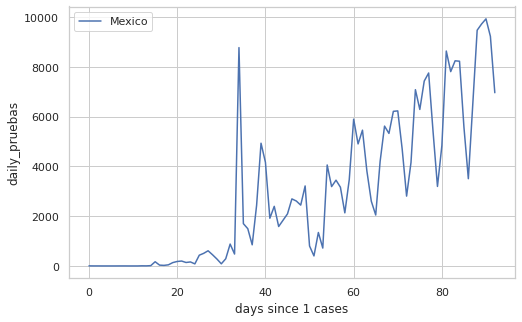

In [13]:
mexico['daily_pruebas'] = mexico['daily_confirmados'].add(mexico['daily_probables']).add(mexico['daily_descartados'])
analysis(mexico, ["Mexico"], "daily_pruebas", since=1, smooth=False, smooth_window=7, log=False)#, show_last_days=50)

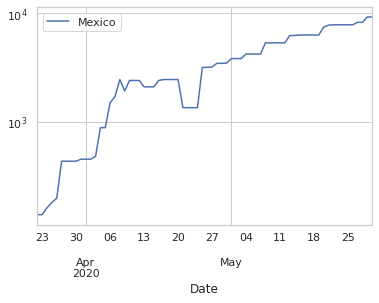

In [37]:
mexico['daily_pruebas'].rolling(window=7).median()[-70:].plot(logy=True)

### México: Positividad 
Proporción de confirmados del total de pruebas reportadas por día

,Mexico
Date,
2020-05-17,0.649046
2020-05-18,0.498863
2020-05-19,0.313932
2020-05-20,0.287689
2020-05-21,0.360407
2020-05-22,0.359572
2020-05-23,0.595954
2020-05-24,0.787913
2020-05-25,0.383133


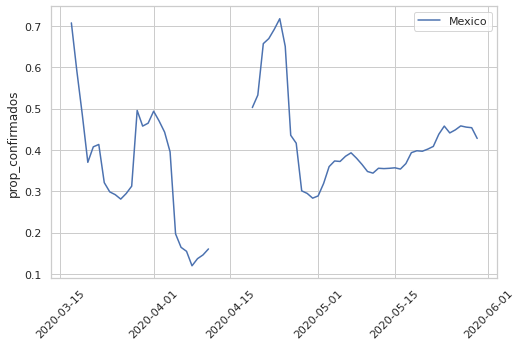

In [15]:
mexico['prop_confirmados'] = mexico['daily_confirmados'] / mexico['daily_pruebas']
analysis(mexico, ['Mexico'], 'prop_confirmados', smooth=True, log=False, since=None)

,Mexico
Date,
2020-05-17,0.285669
2020-05-18,0.291493
2020-05-19,0.292537
2020-05-20,0.292341
2020-05-21,0.295123
2020-05-22,0.297648
2020-05-23,0.305375
2020-05-24,0.313099
2020-05-25,0.315112


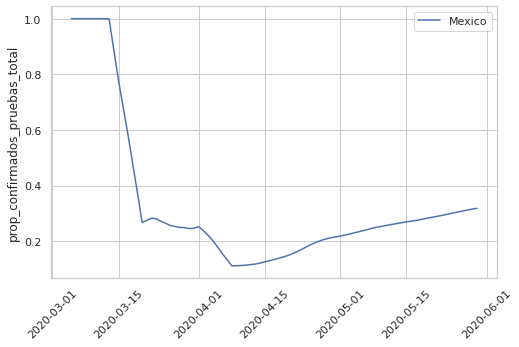

In [16]:
mexico['prop_confirmados_pruebas_total'] = mexico['confirmados'] / mexico['pruebas']
analysis(mexico, ['Mexico'], 'prop_confirmados_pruebas_total', smooth=True, smooth_window=7, log=False, since=None)

### México: proporción de fallecimientos a pruebas, acumulados

,Mexico
Date,
2020-05-17,0.030047
2020-05-18,0.030102
2020-05-19,0.030499
2020-05-20,0.031458
2020-05-21,0.032254
2020-05-22,0.033270
2020-05-23,0.033289
2020-05-24,0.033737
2020-05-25,0.033827


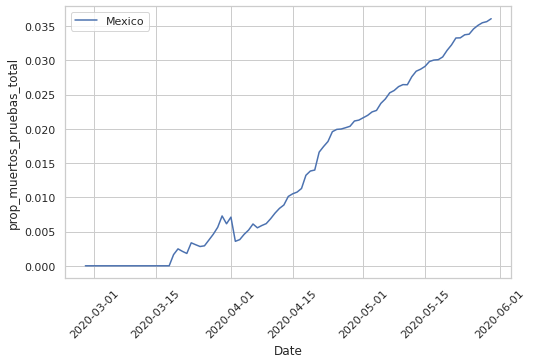

In [17]:
mexico['prop_muertos_pruebas_total'] = mexico['muertos'] / mexico['pruebas']
analysis(mexico, ['Mexico'], 'prop_muertos_pruebas_total', smooth=False, log=False, since=None)

,Mexico
Date,
2020-05-17,0.105183
2020-05-18,0.103267
2020-05-19,0.104258
2020-05-20,0.107609
2020-05-21,0.109289
2020-05-22,0.111776
2020-05-23,0.109011
2020-05-24,0.107753
2020-05-25,0.107348


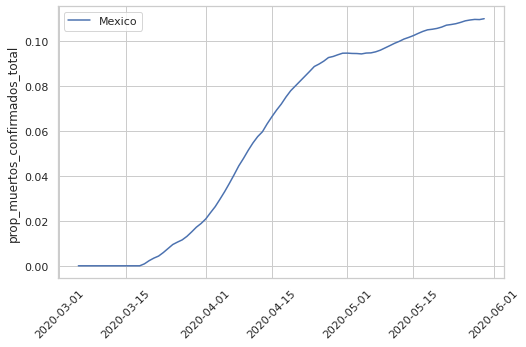

In [18]:
mexico['prop_muertos_confirmados_total'] = mexico['muertos'] / mexico['confirmados']
analysis(mexico, ['Mexico'], 'prop_muertos_confirmados_total', smooth=True, smooth_window=7, log=False, since=None)

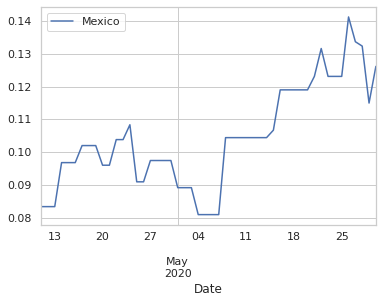

In [19]:
mexico['prop_muertos_confirmados_daily'] = mexico['daily_muertos'] / mexico['daily_confirmados']
mexico['prop_muertos_confirmados_daily'].rolling(window=7).median()[-50:].plot()

## Estados

### Estados: Confirmados acumulados

Estado,Ciudad de México,Nuevo León,Jalisco,Queretaro
Date,,,,
2020-05-17,16298,868,852,442
2020-05-18,17385,884,893,480
2020-05-19,18279,963,927,537
2020-05-20,18993,1023,973,578
2020-05-21,20076,1043,1034,632
2020-05-22,21182,1095,1108,675
2020-05-23,22675,1125,1145,712
2020-05-24,23618,1154,1195,732
2020-05-25,24286,1174,1253,755


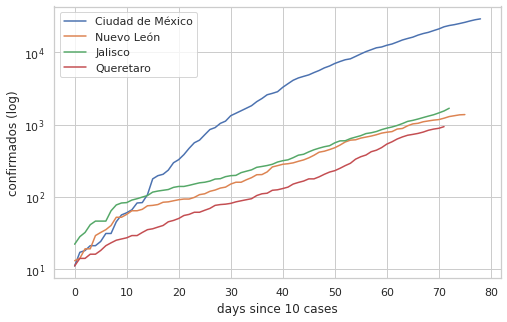

In [20]:
analysis(estados, estados_analisis, "confirmados", since=10, log=True, smooth=False)

### Estados: Confirmados diarios

,Ciudad de México,Nuevo León,Jalisco,Queretaro
Date,,,,
2020-05-17,689,68,50,21
2020-05-18,1087,16,41,38
2020-05-19,894,79,34,57
2020-05-20,714,60,46,41
2020-05-21,1083,20,61,54
2020-05-22,1106,52,74,43
2020-05-23,1493,30,37,37
2020-05-24,943,29,50,20
2020-05-25,668,20,58,23


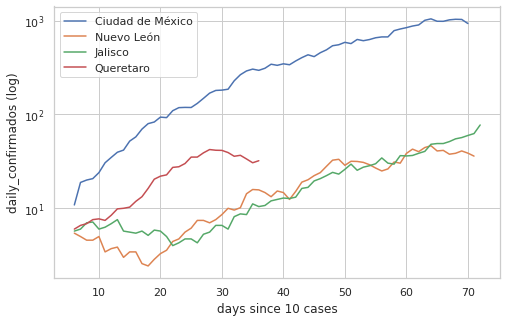

In [21]:
analysis(estados, estados_analisis, "daily_confirmados", since=10, log=True, smooth=True, smooth_window=7)

### Estados: Fallecimientos diarios 

,Ciudad de México,Nuevo León,Jalisco,Queretaro
Date,,,,
2020-05-17,46,0,5,8
2020-05-18,49,0,3,2
2020-05-19,71,5,6,7
2020-05-20,166,2,5,6
2020-05-21,136,2,1,3
2020-05-22,100,4,6,8
2020-05-23,45,0,0,0
2020-05-24,64,0,5,6
2020-05-25,61,5,9,3


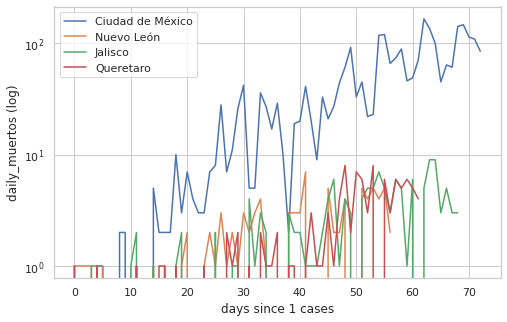

In [22]:
analysis(estados, estados_analisis, "daily_muertos", since=1, log=True, smooth=False)

### Estados: Trayectorias

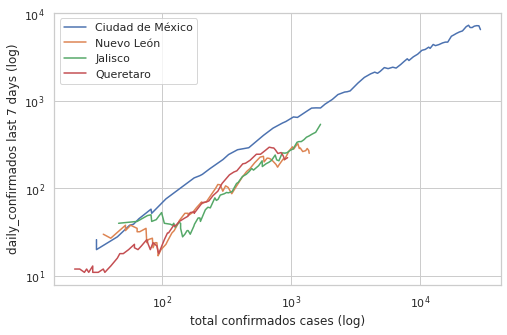

In [40]:
trajectories(estados, estados_analisis, 'confirmados', since=10, window=7)

,Ciudad de México,Nuevo León,Jalisco,Queretaro
Date,,,,
2020-05-17,46303,9603,9084,1594
2020-05-18,47857,9779,9251,1681
2020-05-19,50546,10109,9508,1815
2020-05-20,52782,10466,9761,1926
2020-05-21,55410,10869,10023,2031
2020-05-22,57721,11299,10304,2135
2020-05-23,58937,11684,10547,2180
2020-05-24,59666,11930,10681,2223
2020-05-25,61617,12216,10866,2261


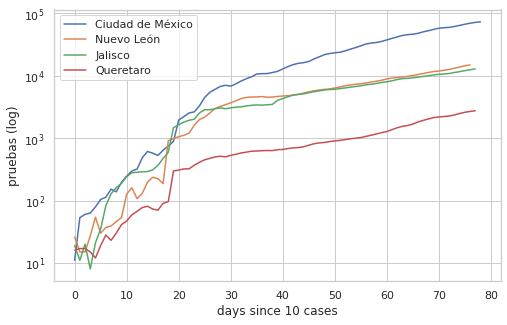

In [24]:
pruebas = {}
for estado in estados['confirmados'].columns:
    pruebas[estado] = estados['confirmados'][estado] + estados['probables'][estado] + estados['descartados'][estado]
estados['pruebas'] = pd.DataFrame(pruebas)
estados['daily_pruebas'] = get_new_per_day(estados['pruebas'])
    
analysis(estados, estados_analisis, "pruebas", since=10, log=True, smooth=False)
#pruebas[-30:].plot(logy=True)

,Ciudad de México,Nuevo León,Jalisco,Queretaro
Date,,,,
2020-05-17,699,216,80,46
2020-05-18,1554,176,167,87
2020-05-19,2689,330,257,134
2020-05-20,2236,357,253,111
2020-05-21,2628,403,262,105
2020-05-22,2311,430,281,104
2020-05-23,1216,385,243,45
2020-05-24,729,246,134,43
2020-05-25,1951,286,185,38


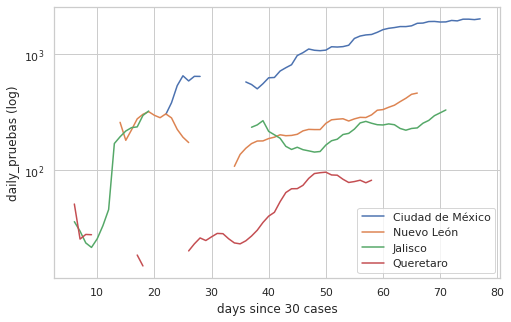

In [25]:
analysis(estados, estados_analisis, "daily_pruebas", since=30, log=True, smooth=True, smooth_window=7)

# Mundo

In [26]:
analysis_countries = ["Mexico", "US", "Spain", "Italy", "Australia", "Korea, South", "Brazil", "United Kingdom"]
world = load_johns_hopkins()

## Mundo: Confirmados acumulados

Country/Region,Mexico,US,Spain,Italy,Australia,"Korea, South",Brazil,United Kingdom
Date,,,,,,,,
2020-05-17,49219,1486757,230698,225435,7054,11065,241080,244995
2020-05-18,51633,1508308,231606,225886,7068,11078,255368,247709
2020-05-19,54346,1528568,232037,226699,7072,11110,271885,250138
2020-05-20,56594,1551853,232555,227364,7081,11122,291579,249619
2020-05-21,59567,1577147,233037,228006,7095,11142,310087,252246
2020-05-22,62527,1600937,234824,228658,7099,11165,330890,255544
2020-05-23,65856,1622612,235290,229327,7114,11190,347398,258504
2020-05-24,68620,1643246,235772,229858,7114,11206,363211,260916
2020-05-25,71105,1662302,235400,230158,7126,11225,374898,262547


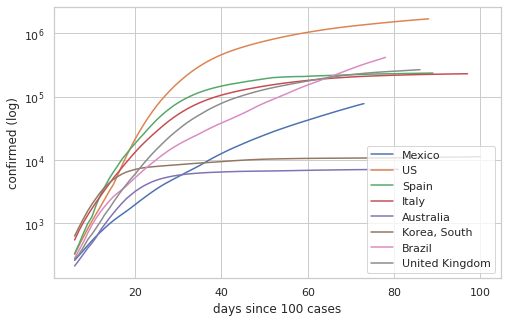

In [27]:
analysis(world, analysis_countries, "confirmed")

## Mundo: Confirmados diarios

,Mexico,US,Spain,Italy,Australia,"Korea, South",Brazil,United Kingdom
Date,,,,,,,,
2020-05-17,2075,18937,0,675,10,15,7569,3534
2020-05-18,2414,21551,908,451,14,13,14288,2714
2020-05-19,2713,20260,431,813,4,32,16517,2429
2020-05-20,2248,23285,518,665,9,12,19694,-519
2020-05-21,2973,25294,482,642,14,20,18508,2627
2020-05-22,2960,23790,1787,652,4,23,20803,3298
2020-05-23,3329,21675,466,669,15,25,16508,2960
2020-05-24,2764,20634,482,531,0,16,15813,2412
2020-05-25,2485,19056,-372,300,12,19,11687,1631


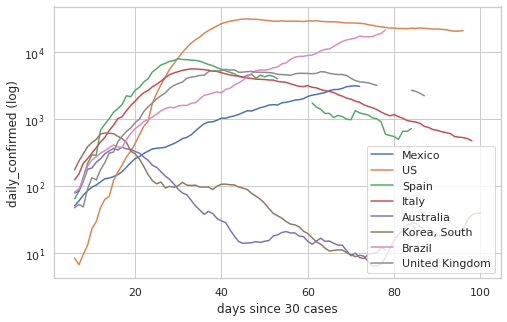

In [28]:
analysis(world, analysis_countries, "daily_confirmed", since=30)

## Mundo: Fallecimientos acumulados

Country/Region,Mexico,US,Spain,Italy,Australia,"Korea, South",Brazil,United Kingdom
Date,,,,,,,,
2020-05-17,5177,89562,27563,31908,99,263,16118,34716
2020-05-18,5332,90347,27709,32007,99,263,16853,34876
2020-05-19,5666,91921,27778,32169,100,263,17983,35422
2020-05-20,6090,93439,27888,32330,100,264,18859,35786
2020-05-21,6510,94702,27940,32486,101,264,20047,36124
2020-05-22,6989,95978,28628,32616,101,266,21048,36475
2020-05-23,7179,97086,28678,32735,102,266,22013,36757
2020-05-24,7394,97719,28752,32785,102,267,22666,36875
2020-05-25,7633,98219,26834,32877,102,269,23473,36996


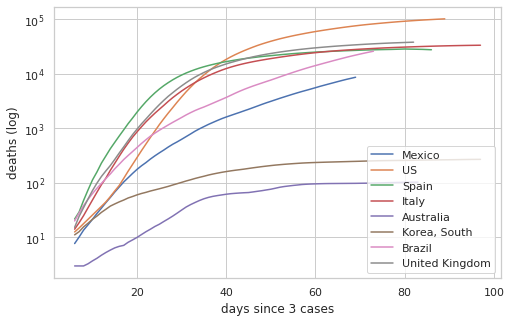

In [29]:
analysis(world, analysis_countries, "deaths", since=3)

## Mundo: Fallecimientos diarios

,Mexico,US,Spain,Italy,Australia,"Korea, South",Brazil,United Kingdom
Date,,,,,,,,
2020-05-17,132,808,0,145,1,1,456,170
2020-05-18,155,785,146,99,0,0,735,160
2020-05-19,334,1574,69,162,1,0,1130,546
2020-05-20,424,1518,110,161,0,1,876,364
2020-05-21,420,1263,52,156,1,0,1188,338
2020-05-22,479,1276,688,130,0,2,1001,351
2020-05-23,190,1108,50,119,1,0,965,282
2020-05-24,215,633,74,50,0,1,653,118
2020-05-25,239,500,-1918,92,0,2,807,121


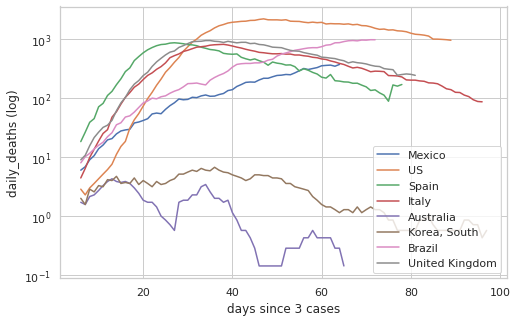

In [30]:
analysis(world, analysis_countries, "daily_deaths", since=3)

## Mundo: Trayectorias de casos confirmados

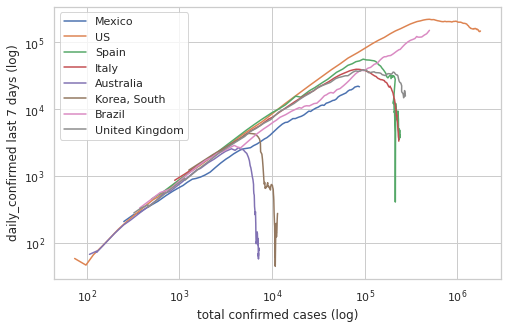

In [31]:
trajectories(world, analysis_countries, 'confirmed', since=50, window=7)

## Querétaro

Estado,Ciudad de México,Queretaro
Date,,
2020-05-17,16298,442
2020-05-18,17385,480
2020-05-19,18279,537
2020-05-20,18993,578
2020-05-21,20076,632
2020-05-22,21182,675
2020-05-23,22675,712
2020-05-24,23618,732
2020-05-25,24286,755


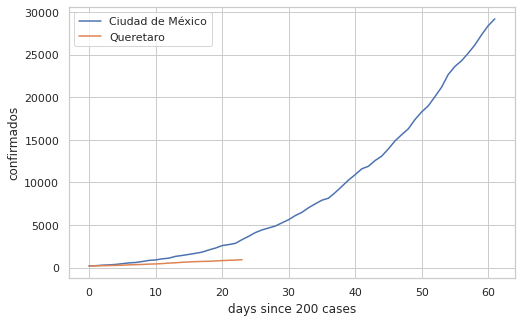

In [32]:
analysis(estados, ["Ciudad de México", "Queretaro"], "confirmados", since=200, log=False, smooth=False, smooth_window=7)

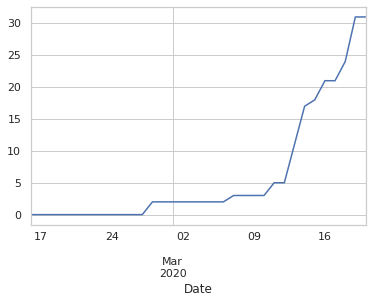

In [33]:
estados['confirmados']['Ciudad de México']['2020-02-16':'2020-03-20'].rolling(window=1).sum().plot()

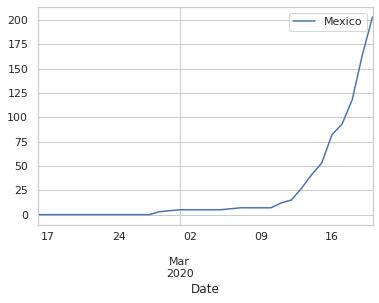

In [34]:
mexico['confirmados']['2020-02-16':'2020-03-20'].plot()

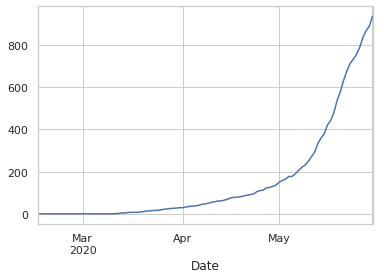

In [41]:
estados['confirmados']['Queretaro']['2020-02-16':].plot()

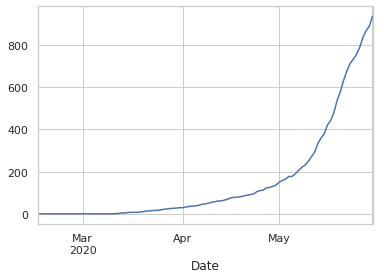

In [36]:
estados['confirmados']['Queretaro']['2020-02-16':].plot()